In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasdata.dataloader.loader import Loader
from sasmodels import weights

from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty
from bumps import parameter

import matplotlib.pyplot as plt

import glob

from saxs_data_processing import subtract, io
import pandas as pd

import matplotlib.pyplot as plt

import os

## Load data

Ideal: Pass a UUID and a background filepath, workflow figures it out/

In [27]:
def saxs_fit_monofunc(signal_fp, background_fp):
    signal, background = load_data(signal_fp, background_fp)

    subtracted = subtract.chop_subtract(signal, background)

    data = df2data(subtracted)
    data.qmin = data.x.min()
    data.qmax = data.x.max()
    data.mask = np.isnan(data.y)

    sphere_results, sphere_result_obj, sphere_problem = fit_sphere(data)
    power_law_results, power_law_result_obj, power_law_problem = fit_power_law(data)
    guinierporod_results, guinierporod_result_obj, guinierporod_problem = fit_guinier_porod(data)

    fig, ax = plt.subplots(1,3, figsize = (12,4))
    ax[0].set_title('sphere')
    ax[1].set_title('Power law')
    ax[2].set_title('Guinier-Porod')
    
    for i, problem in enumerate([sphere_problem, power_law_problem, guinierporod_problem]):
        for j, model in enumerate(problem.models):
            data = model._data
            Icalc = model.Iq_calc
            chisq = problem.chisq_str()
            ax[i].loglog(data.x, data.y, ls = '', marker = '.', label = 'observed')
            ax[i].loglog(data.x, Icalc, ls = '-', label = 'fit')
            ax[i].text(0.003, 0.1, 'Chisq: ' + chisq)

    return {'sphere_results':sphere_results, 'power_law_results':power_law_results, 'guinierporod_results':guinierporod_results}

In [3]:
def data2df(data):
    """
    Convert a sasdata data object into a dataframe compatible with Brenden's processing tools
    """

    return pd.DataFrame({'q':data.x, 'I':data.y, 'sig':data.dy})

In [5]:
def load_data(signal_fp, background_fp):

    signal = io.read_1D_data(signal_fp)
    background = io.read_1D_data(background_fp)

    assert signal[1]['BIO_SYSTEM_CONF'] == background[1]['BIO_SYSTEM_CONF'], 'different configs between signal and background'

    return signal[0], background[0]

    

In [12]:
def df2data(df):
    fp = 'temp.dat'
    io.write_dat(df, {'metadata':None}, fp)
    loader = Loader()
    data = loader.load(fp)
    os.remove(fp)
    return data[0]

In [14]:
def fit_sphere(data, polydispersity = True, ax = None):

    kernel = load_model('sphere')
    

    
    #set up model
    pars = dict(scale = 1, background = 0.001, sld = 1, radius = 50)
    model = Model(kernel, **pars)
    model.radius.range(10, 5000)
    model.scale.range(0, 5)
    if polydispersity:
        model.radius_pd.range(0,0.2)
        model.radius_pd_type = 'lognormal'
        
    M = Experiment(data = data, model = model)
    problem = FitProblem(M)
    
    
    result = fit(problem, method='amoeba')

    results = {}

    for l, v, dv in zip(problem.labels(), result.x, result.dx):
        results[l] = v
        results[l+'_uncertainty'] = dv

    results['chisq'] = problem.chisq_str()
    
    return results, result, problem

In [17]:
def fit_power_law(data, ax = None):
    kernel = load_model('power_law')

    pars = dict(scale = 1, background = 0.001, power = 4.0)
    model = Model(kernel, **pars)
    model.power.range(0, 10)
    model.scale.range(0, 5)
        
    M = Experiment(data = data, model = model)
    problem = FitProblem(M)

    result = fit(problem, method='amoeba')
    
    results = {}
    for l, v, dv in zip(problem.labels(), result.x, result.dx):
        results[l] = v
        results[l+'_uncertainty'] = dv
    results['chisq'] = problem.chisq_str()


    return results, result, problem

In [19]:
def fit_guinier_porod(data, ax = None):
    
    kernel = load_model('guinier_porod')
    
    pars = dict(scale = 1, background = 0.001, rg = 60, s = 1.0, porod_exp = 3.0)
    model = Model(kernel, **pars)
    model.scale.range(0, 5)
    model.rg.range(0, 500)
    model.s.range(0,10)
    model.porod_exp.range(0,10)
        
    M = Experiment(data = data, model = model)
    problem = FitProblem(M)
    
    
    result = fit(problem, method='amoeba')

    results = {}

    for l, v, dv in zip(problem.labels(), result.x, result.dx):
        results[l] = v
        results[l+'_uncertainty'] = dv

    results['chisq'] = problem.chisq_str()
    
    return results, result, problem

In [24]:
#signal_fp = "/home/bgpelkie/stober_temp/2024_10_15_Highlights_replicates/03361_A3-T2_130093e4-2947-4d37-b73a-ed4c23442ab8_000.dat"
signal_fp = "/home/bgpelkie/stober_temp/2024_10_07_randomcampaignV3/data/03241_D12-T1_403cbac3-a2e0-44f0-aca4-9313b8775a4e_000.dat"
background_fp = "/home/bgpelkie/stober_temp/2024_10_15_Highlights_replicates/03357_D5-T2_Background_1_EtOH_000.dat"

{'sphere_results': {'radius': 689.3393822345063,
  'radius_uncertainty': 2.058705056658371,
  'radius_pd': 0.19999999999998339,
  'radius_pd_uncertainty': 0.0026772798760166133,
  'scale': 0.00012735072097270488,
  'scale_uncertainty': 4.796151674665235e-07,
  'chisq': '114.866(29)'},
 'power_law_results': {'power': 4.473841564701445,
  'power_uncertainty': 0.007670337452571031,
  'scale': 8.838805014015887e-10,
  'scale_uncertainty': 3.838805818476622e-11,
  'chisq': '21.609(19)'},
 'guinierporod_results': {'porod_exp': 4.473840551696257,
  'porod_exp_uncertainty': 0.007692956381144843,
  'rg': 377.2818859664692,
  'rg_uncertainty': 99999999.99991101,
  's': 2.6779039066449855,
  's_uncertainty': 99999944.25044772,
  'scale': 0.00028034397358565975,
  'scale_uncertainty': 105593.20601810675,
  'chisq': '21.966(39)'}}

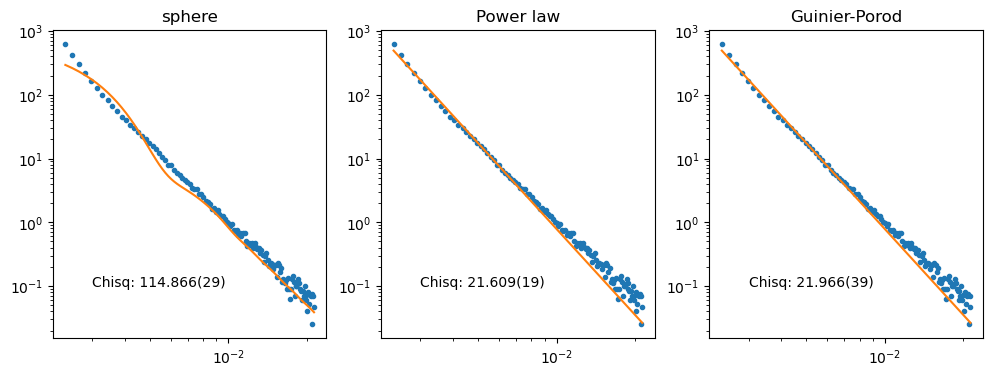

In [28]:
saxs_fit_monofunc(signal_fp, background_fp)

## Subtract and chop

## Format conversion

Convert my df format back to sasdata's format by writing to file then re-loading

## Fit sphere model

## Fit power law model

## Fit guinier-porod 

114.866(29)
21.609(19)
21.966(39)


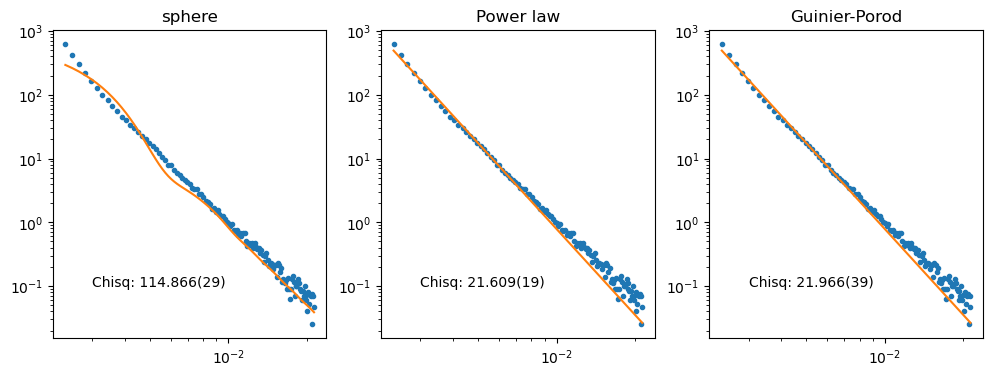